In [1]:
import spiketoolkit as st
import spikesorters as ss
import spikeextractors as se
import numpy as np
import spikemetrics.metrics as metrics
from spikemetrics.utils import Epoch
from collections import OrderedDict

15:15:31 [I] klustakwik KlustaKwik2 version 0.2.6


In [2]:
workshop_path = "/Users/colehurwitz/spiketutorials/Spike_sorting_workshop_2019/"
# workshop_path = "/afs/inf.ed.ac.uk/user/s17/s1727843/spiketutorials/Spike_sorting_workshop_2019/"
recording = se.MEArecRecordingExtractor(recording_path= workshop_path + "recordings_36cells_four-tetrodes_30.0_10.0uV_20-06-2019_14_48.h5")


Could not load plane information. Assuming probe is in yz plane


In [3]:
recording = se.load_probe_file(recording, workshop_path + 'tetrode_16.prb')

In [4]:
sorting = ss.run_klusta(recording)

Klusta units are not unique! Using unique unit ids


In [5]:
metric_info = st.validation.validation_tools.get_quality_metric_data(recording, sorting, nPC=3, ms_before=1., ms_after=2., dtype=None, max_num_waveforms=np.inf, 
                                                        max_num_pca_waveforms=np.inf, save_features_props=False, verbose=False, seed=0)

spike_times = metric_info[0]
spike_clusters = metric_info[1]
amplitudes = metric_info[2]
pc_features = metric_info[3]
pc_feature_ind = metric_info[4]

In [6]:
params = st.validation.qualitymetrics.MetricCalculator.get_default_params_dict()

In [7]:
start_epoch = Epoch("start", 0, 15)
end_epoch = Epoch("end", 15, 30)
epochs = [start_epoch, end_epoch]
unit_ids = sorting.get_unit_ids()#[1,2,3,12,22]

In [8]:
metrics_pd = metrics.calculate_metrics(spike_times=spike_times, spike_clusters=spike_clusters, amplitudes=amplitudes, 
                                       pc_features=pc_features, pc_feature_ind=pc_feature_ind, params=params, epochs = epochs, cluster_ids=sorting.get_unit_ids())

Calculating isi violations
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating presence ratio
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating firing rate
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating amplitude cutoff
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating PC-based metrics
 ▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 14% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 28% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░ 38% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░ 48% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░ 59% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░ 86% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating silhouette score
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating drift metrics
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating isi violations
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating presence ratio
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating firing rate
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating amplitude cutoff
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating PC-based metrics
 ▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 3% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/spikemetrics-0.1.0-py3.7.egg/spikemetrics/metrics.py:371: RuntimeWarning: All-NaN slice encountered
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/spikemetrics-0.1.0-py3.7.egg/spikemetrics/metrics.py:413: RuntimeWarning: All-NaN slice encountered


 ▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 17% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░ 34% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░ 41% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░ 52% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░ 72% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░ 86% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating silhouette score
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
Calculating drift metrics
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 


/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/spikemetrics-0.1.0-py3.7.egg/spikemetrics/metrics.py:371: RuntimeWarning: All-NaN slice encountered


In [9]:
# index_amps = [0]*len(amplitudes)
# amplitudes_array = np.zeros(len(spike_clusters))
# for i, spike_cluster in enumerate(spike_clusters):
#     amplitudes_array[i] = amplitudes[spike_cluster][index_amps[spike_cluster]]
#     index_amps[spike_cluster] += 1

In [10]:
st.validation.qualitymetrics.MetricCalculator.get_default_params_dict()

{'isi_threshold': 0.0015,
 'min_isi': 0.000166,
 'num_channels_to_compare': 13,
 'max_spikes_for_unit': 500,
 'max_spikes_for_nn': 10000,
 'n_neighbors': 4,
 'n_silhouette': 10000,
 'quality_metrics_output_file': 'metrics.csv',
 'drift_metrics_interval_s': 51,
 'drift_metrics_min_spikes_per_interval': 10}

In [37]:
epoch_tuples = [(start_epoch.start_time, start_epoch.end_time), (end_epoch.start_time, end_epoch.end_time)]
epoch_names = ["start", "end"]

metric_calculator = st.validation.qualitymetrics.MetricCalculator(sorting, sampling_frequency=sorting.get_sampling_frequency(), unit_ids=unit_ids, \
                                                                  epoch_tuples=epoch_tuples, epoch_names=epoch_names)

In [38]:
metric_calculator.store_all_metric_data(recording, nPC=3, ms_before=1., ms_after=2., dtype=None, max_num_waveforms=np.inf, \
                                        amp_method='absolute', amp_peak='both', amp_frames_before=3, amp_frames_after=3, \
                                        max_num_pca_waveforms=np.inf, save_features_props=False)
# metric_calculator.store_amplitudes(recording, amp_method='absolute', amp_peak='both', amp_frames_before=3, \
#                                    amp_frames_after=3, save_features_props=False)


In [39]:
firing_rates = metric_calculator.compute_firing_rates()

num_spikes = metric_calculator.compute_num_spikes()

presence_ratios = metric_calculator.compute_presence_ratios()

isi_violations = metric_calculator.compute_isi_violations(isi_threshold=0.0015, min_isi=0.000166)

amplitude_cutoffs = metric_calculator.compute_amplitude_cutoffs()

max_drifts, cumulative_drifts = metric_calculator.compute_drift_metrics(drift_metrics_interval_s=51, drift_metrics_min_spikes_per_interval=10)

silhouette_scores = metric_calculator.compute_silhouette_score(seed=0)

isolation_distances = metric_calculator.compute_isolation_distances(num_channels_to_compare=13, max_spikes_for_unit=500, seed=0)

l_ratios = metric_calculator.compute_l_ratios(num_channels_to_compare=13, max_spikes_for_unit=500, seed=0)

d_primes = metric_calculator.compute_d_primes(num_channels_to_compare=13, max_spikes_for_unit=500, seed=0)

nn_hit_rates, nn_miss_rates = metric_calculator.compute_nn_metrics(num_channels_to_compare=13, max_spikes_for_unit=500, max_spikes_for_nn=10000, n_neighbors=4, seed=0)

 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 


AssertionError: Compute data for all metrics first

In [15]:
def nan_equal(a,b):
    try:
        np.testing.assert_equal(a,b)
    except AssertionError:
        return False
    return True

In [40]:
metrics_dict = metric_calculator.get_metrics_dict()

print(nan_equal(np.asarray(metrics_dict['num_spikes']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['num_spikes'])))
print(nan_equal(np.asarray(metrics_dict['firing_rate']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['firing_rate'])))
print(nan_equal(np.asarray(metrics_dict['isi_viol']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['isi_viol'])))
print(nan_equal(np.asarray(metrics_dict['presence_ratio']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['presence_ratio'])))
print(nan_equal(np.asarray(metrics_dict['amplitude_cutoff']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['amplitude_cutoff'])))
print(nan_equal(np.asarray(metrics_dict['max_drift']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['max_drift'])))
print(nan_equal(np.asarray(metrics_dict['cumulative_drift']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['cumulative_drift'])))
print(nan_equal(np.asarray(metrics_dict['silhouette_score']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['silhouette_score'])))
print(nan_equal(np.asarray(metrics_dict['isolation_distance']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['isolation_distance'])))
print(nan_equal(np.asarray(metrics_dict['l_ratio']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['l_ratio'])))
print(nan_equal(np.asarray(metrics_dict['d_prime']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['d_prime'])))
print(nan_equal(np.asarray(metrics_dict['nn_hit_rate']).flatten().flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['nn_hit_rate'])))
print(nan_equal(np.asarray(metrics_dict['nn_miss_rate']).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['nn_miss_rate'])))

True
True
True
True
True


KeyError: 'max_drift'

In [17]:
metric_names = ['firing_rate', 'num_spikes', 'isi_viol', 'presence_ratio', 'amplitude_cutoff', 'snr', 'max_drift', 'cumulative_drift', 'silhouette_score', 'isolation_distance', \
                'l_ratio', 'd_prime', 'nn_hit_rate', 'nn_miss_rate']

metrics_epochs = metric_calculator.compute_metrics(isi_threshold=0.0015, min_isi=0.000166, drift_metrics_interval_s=51, \
                                                   drift_metrics_min_spikes_per_interval=10, max_spikes_for_silhouette=10000, \
                                                   num_channels_to_compare=13, max_spikes_for_unit=500, max_spikes_for_nn=10000, \
                                                   n_neighbors=4, metric_names=metric_names, seed=0)

 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 


/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/spikemetrics-0.1.0-py3.7.egg/spikemetrics/metrics.py:413: RuntimeWarning: All-NaN slice encountered


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 10% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/spikemetrics-0.1.0-py3.7.egg/spikemetrics/metrics.py:371: RuntimeWarning: All-NaN slice encountered


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░ 45% 

/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/spikemetrics-0.1.0-py3.7.egg/spikemetrics/metrics.py:371: RuntimeWarning: All-NaN slice encountered
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/colehurwitz/miniconda3/envs/spikeinterface/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 
 ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ 100% 


In [18]:
print(nan_equal(np.hstack(metrics_epochs[0]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['num_spikes'])))
print(nan_equal(np.hstack(metrics_epochs[1]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['firing_rate'])))
print(nan_equal(np.hstack(metrics_epochs[2]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['presence_ratio'])))
print(nan_equal(np.hstack(metrics_epochs[3]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['isi_viol'])))
print(nan_equal(np.hstack(metrics_epochs[4]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['amplitude_cutoff'])))
print(nan_equal(np.hstack(metrics_epochs[6]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['max_drift'])))
print(nan_equal(np.hstack(metrics_epochs[7]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['cumulative_drift'])))
print(nan_equal(np.hstack(metrics_epochs[8]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['silhouette_score'])))
print(nan_equal(np.hstack(metrics_epochs[9]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['isolation_distance'])))
print(nan_equal(np.hstack(metrics_epochs[10]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['l_ratio'])))
print(nan_equal(np.hstack(metrics_epochs[11]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['d_prime'])))
print(nan_equal(np.hstack(metrics_epochs[12]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['nn_hit_rate'])))
print(nan_equal(np.hstack(metrics_epochs[13]).flatten(), np.asarray(metrics_pd.loc[metrics_pd['cluster_id'].isin(unit_ids)]['nn_miss_rate'])))

True
True
True
True
True
True
True
True
True
True
True
True
True


In [19]:
metric_calculator.get_metrics_df()

,unit_ids,firing_rate,num_spikes,presence_ratio,isi_viol,amplitude_cutoff,max_drift,cumulative_drift,silhouette_score,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,snr,epoch_name,epoch_start,epoch_end
0,0,2.334987,35.0,0.28,13.758873,0.007394,0.0,0.0,NaN,1.431536e+01,1.058970e-01,2.520144,0.352381,0.010449,10.554014,start,0,15
1,1,3.268982,49.0,0.39,0.000000,0.170419,0.0,0.0,0.235637,1.995726e+02,4.278276e-15,5.902837,0.891156,0.002788,8.936044,start,0,15
2,2,1.667848,25.0,0.23,0.000000,0.010351,0.0,0.0,0.181339,4.877675e+14,NaN,4.258777,0.520000,0.002925,5.563270,start,0,15
3,3,13.943210,209.0,0.91,0.000000,0.001238,0.0,0.0,0.293168,1.961687e+02,4.569695e-04,6.184044,0.963317,0.012640,9.865364,start,0,15
4,4,11.141225,167.0,0.79,0.000000,0.001550,0.0,0.0,0.170594,1.485608e+02,8.255000e-03,4.942970,0.944112,0.008220,8.461314,start,0,15
5,5,2.134846,32.0,0.23,0.000000,0.008087,0.0,0.0,0.087522,1.258476e+02,7.915338e-05,4.325952,0.645833,0.005679,6.160199,start,0,15
6,6,1.467706,22.0,0.19,0.000000,0.011763,0.0,0.0,0.047032,1.991707e+14,NaN,2.005472,0.545455,0.004159,5.037015,start,0,15
7,7,4.803402,72.0,0.51,0.000000,0.003594,0.0,0.0,0.127066,9.359847e+01,1.223686e-06,3.110142,0.902778,0.008917,8.900904,start,0,15
8,8,4.202977,63.0,0.42,0.000000,0.500000,0.0,0.0,0.177179,1.831721e+02,2.692126e-06,7.125779,0.947090,0.003906,13.906317,start,0,15
9,9,15.677772,235.0,0.87,0.000000,0.001101,0.0,0.0,0.192339,1.150063e+02,2.126223e-04,4.681344,0.948936,0.012837,5.534759,start,0,15


In [20]:
import matplotlib.pyplot as plt

In [21]:
sorting.get_unit_spike_train(unit_id=1)

array([ 38348,  54373,  61801,  72571,  75015,  80118,  82298,  91207,
        97488, 103599, 110700, 127701, 133958, 138103, 142939, 144002,
       151582, 161925, 181985, 184881, 203294, 225461, 226978, 227230,
       257178, 299707, 305406, 340074, 354245, 355114, 356667, 369071,
       369940, 370508, 376384, 385991, 388689, 396436, 415031, 421589,
       424028, 431249, 436769, 440140, 452204, 455423, 456883, 461791,
       475009, 483303, 484115, 484239, 486848, 487672, 488251, 488807,
       489555, 491676, 506748, 510579, 529664, 537301, 538256, 539968,
       549545, 549928, 553363, 554737, 560324, 560809, 573763, 576365,
       584996, 590983, 592464, 601952, 604183, 604872, 604946, 616576,
       618421, 624763, 627001, 638989, 644774, 646715, 664410, 665031,
       682510, 686204, 688098, 691424, 694655, 706191, 706438, 710387,
       714029, 717915, 729560, 735782, 737102, 749727, 753594, 757516,
       759208, 775999, 778643, 792980, 807555, 826502, 828654, 832384,
      

In [22]:
spike_times = metric_calculator._sorting.get_epoch('end').get_unit_spike_train(unit_id= 1, start_frame=0, end_frame=None)
print(spike_times)

[  3303   4115   4239   6848   7672   8251   8807   9555  11676  26748
  30579  49664  57301  58256  59968  69545  69928  73363  74737  80324
  80809  93763  96365 104996 110983 112464 121952 124183 124872 124946
 136576 138421 144763 147001 158989 164774 166715 184410 185031 202510
 206204 208098 211424 214655 226191 226438 230387 234029 237915 249560
 255782 257102 269727 273594 277516 279208 295999 298643 312980 327555
 346502 348654 352384 357435 370243 375921 378949 385460 396143 403622
 410620 439552 439838 439943 442797 444736 445418 447666 451401 452706
 460953 466053 474545]


In [23]:
metric_calculator._recording.get_epoch('end').get_traces()

array([[ 8.98955260e+00, -2.51620014e+00,  1.51361870e+01, ...,
         1.59282992e+01, -3.13036671e+00, -4.71413765e+00],
       [ 6.02915416e+00,  7.98677924e+00,  1.20891864e+01, ...,
        -3.02472798e+01, -2.07995460e+01, -1.30439657e+01],
       [ 9.84063254e+00,  4.99690787e+00,  1.52650225e+01, ...,
        -3.15657410e-03,  8.50290517e+00, -9.69653826e+00],
       ...,
       [ 1.66177539e+00,  2.14047085e+01, -6.08228398e+00, ...,
         1.90511275e+00,  9.66105623e+00, -1.97181876e+00],
       [-1.66863929e+00,  6.70771459e+00,  1.18385989e+01, ...,
        -5.19323510e+00,  9.77574656e+00,  9.03375043e+00],
       [-8.61905357e+00, -4.08932845e+00,  1.20199058e+01, ...,
         1.01300330e+01,  3.72652518e+00,  1.17578334e+01]])

In [24]:
np.array_equal(recording.get_traces(),  np.concatenate((metric_calculator._recording.get_epoch('start').get_traces(), metric_calculator._recording.get_epoch('end').get_traces()),axis=1))

True

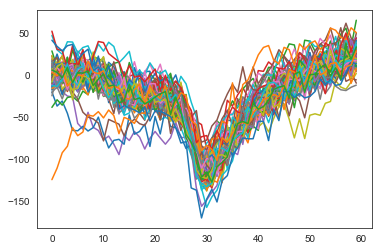

In [25]:
spike_times = metric_calculator._sorting.get_epoch('end').get_unit_spike_train(unit_id= 1, start_frame=0, end_frame=None)
for snippets in metric_calculator._recording.get_epoch('end').get_snippets(channel_ids=[15],reference_frames=spike_times, snippet_len=60):
    for snippet in snippets:
        plt.plot(snippet)

In [26]:
metric_calculator._recording.get_epoch('end').get_traces(start_frame=0, end_frame=3303)

array([[   8.9895526 ,   -2.51620014,   15.13618703, ...,  -40.23667604,
         -33.66991435,  -36.17826169],
       [   6.02915416,    7.98677924,   12.08918638, ...,  -48.19745344,
         -16.55206408,  -60.71450971],
       [   9.84063254,    4.99690787,   15.26502253, ...,  -72.60675242,
         -78.1327281 , -117.26620656],
       ...,
       [   1.66177539,   21.4047085 ,   -6.08228398, ...,   -4.00559964,
           0.70920253,  -23.37528077],
       [  -1.66863929,    6.70771459,   11.8385989 , ...,   10.21385999,
          11.22782117,   23.3081557 ],
       [  -8.61905357,   -4.08932845,   12.01990584, ...,    4.25010316,
          11.07546667,    9.25552052]])

In [27]:
recording.get_traces(start_frame=480000, end_frame=483303)

array([[   8.9895526 ,   -2.51620014,   15.13618703, ...,  -40.23667604,
         -33.66991435,  -36.17826169],
       [   6.02915416,    7.98677924,   12.08918638, ...,  -48.19745344,
         -16.55206408,  -60.71450971],
       [   9.84063254,    4.99690787,   15.26502253, ...,  -72.60675242,
         -78.1327281 , -117.26620656],
       ...,
       [   1.66177539,   21.4047085 ,   -6.08228398, ...,   -4.00559964,
           0.70920253,  -23.37528077],
       [  -1.66863929,    6.70771459,   11.8385989 , ...,   10.21385999,
          11.22782117,   23.3081557 ],
       [  -8.61905357,   -4.08932845,   12.01990584, ...,    4.25010316,
          11.07546667,    9.25552052]])

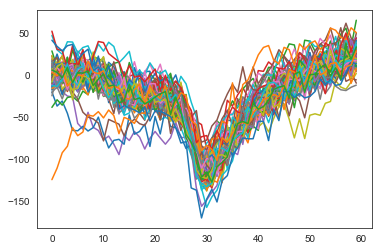

In [28]:
spike_times = sorting.get_unit_spike_train(unit_id= 1, start_frame=480000, end_frame=960000)
for snippets in recording.get_snippets(channel_ids=[15],reference_frames=spike_times, snippet_len=60):
    for snippet in snippets:
        plt.plot(snippet)

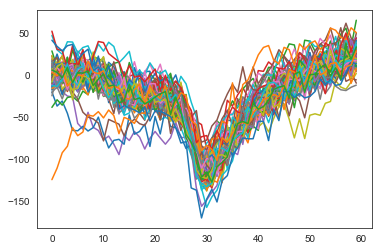

In [29]:
spike_times = metric_calculator._sorting.get_epoch('end').get_unit_spike_train(unit_id= 1, start_frame=0, end_frame=None)
for snippets in metric_calculator._recording.get_epoch('end').get_snippets(channel_ids=[15],reference_frames=spike_times, snippet_len=60):
    for snippet in snippets:
        plt.plot(snippet)

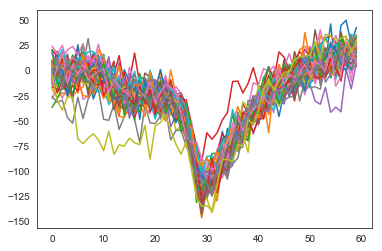

In [30]:
spike_times = metric_calculator._sorting.get_epoch('start').get_unit_spike_train(unit_id= 1, start_frame=0, end_frame=None)
for snippets in metric_calculator._recording.get_epoch('start').get_snippets(channel_ids=[15],reference_frames=spike_times, snippet_len=60):
    for snippet in snippets:
        plt.plot(snippet)

In [31]:
metric_calculator._recording.get_epoch('start').get_snippets(channel_ids=[10],reference_frames=spike_times, snippet_len=60)

array([[[ 14.76259585,  23.43929226,  13.99708711, ..., -12.10370541,
          -7.96145951,   7.51207686]],

       [[ 19.9501606 , -11.19564833,  -0.88297138, ...,  14.67805149,
           2.17110577,  33.77655146]],

       [[ 18.99415068,   6.11663865,  -1.61879711, ...,  -1.36439155,
          -2.77200607,  -7.74432567]],

       ...,

       [[  8.86009905, -12.04446465,   4.44349253, ..., -19.15480125,
           3.55511085,   5.7727217 ]],

       [[-16.80524311,   1.72182926, -14.23843173, ...,   7.76263702,
          -8.87142609,  -2.20416771]],

       [[ -4.87289837,  -8.49831216, -19.15858378, ...,  12.76024593,
          35.7973786 ,  34.5858678 ]]])

In [32]:
metric_calculator._sorting.get_epoch('start').get_unit_spike_train(unit_id= 1, start_frame=0, end_frame=None)

array([ 38348,  54373,  61801,  72571,  75015,  80118,  82298,  91207,
        97488, 103599, 110700, 127701, 133958, 138103, 142939, 144002,
       151582, 161925, 181985, 184881, 203294, 225461, 226978, 227230,
       257178, 299707, 305406, 340074, 354245, 355114, 356667, 369071,
       369940, 370508, 376384, 385991, 388689, 396436, 415031, 421589,
       424028, 431249, 436769, 440140, 452204, 455423, 456883, 461791,
       475009], dtype=uint64)

In [33]:
metric_calculator._sorting.get_epoch('end').get_unit_spike_train(unit_id=1, start_frame=0, end_frame=None)

array([  3303,   4115,   4239,   6848,   7672,   8251,   8807,   9555,
        11676,  26748,  30579,  49664,  57301,  58256,  59968,  69545,
        69928,  73363,  74737,  80324,  80809,  93763,  96365, 104996,
       110983, 112464, 121952, 124183, 124872, 124946, 136576, 138421,
       144763, 147001, 158989, 164774, 166715, 184410, 185031, 202510,
       206204, 208098, 211424, 214655, 226191, 226438, 230387, 234029,
       237915, 249560, 255782, 257102, 269727, 273594, 277516, 279208,
       295999, 298643, 312980, 327555, 346502, 348654, 352384, 357435,
       370243, 375921, 378949, 385460, 396143, 403622, 410620, 439552,
       439838, 439943, 442797, 444736, 445418, 447666, 451401, 452706,
       460953, 466053, 474545], dtype=uint64)

In [34]:
metric_calculator._sorting.get_epoch_info('end')

{'start_frame': 480000, 'end_frame': 960000}

In [35]:
metric_calculator._sorting.get_epoch_info('end')

{'start_frame': 480000, 'end_frame': 960000}

In [36]:
metrics_pd

,cluster_id,num_spikes,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,silhouette_score,max_drift,cumulative_drift,epoch_name
0,0,35.0,2.334987,0.28,13.758873,0.007394,1.431536e+01,1.058970e-01,2.520144,0.352381,0.010449,NaN,0.0,0.0,start
1,1,49.0,3.268982,0.39,0.000000,0.170419,1.995726e+02,4.278276e-15,5.902837,0.891156,0.002788,0.235637,0.0,0.0,start
2,2,25.0,1.667848,0.23,0.000000,0.010351,4.877675e+14,NaN,4.258777,0.520000,0.002925,0.181339,0.0,0.0,start
3,3,209.0,13.943210,0.91,0.000000,0.001238,1.961687e+02,4.569695e-04,6.184044,0.963317,0.012640,0.293168,0.0,0.0,start
4,4,167.0,11.141225,0.79,0.000000,0.001550,1.485608e+02,8.255000e-03,4.942970,0.944112,0.008220,0.170594,0.0,0.0,start
5,5,32.0,2.134846,0.23,0.000000,0.008087,1.258476e+02,7.915338e-05,4.325952,0.645833,0.005679,0.087522,0.0,0.0,start
6,6,22.0,1.467706,0.19,0.000000,0.011763,1.991707e+14,NaN,2.005472,0.545455,0.004159,0.047032,0.0,0.0,start
7,7,72.0,4.803402,0.51,0.000000,0.003594,9.359847e+01,1.223686e-06,3.110142,0.902778,0.008917,0.127066,0.0,0.0,start
8,8,63.0,4.202977,0.42,0.000000,0.500000,1.831721e+02,2.692126e-06,7.125779,0.947090,0.003906,0.177179,0.0,0.0,start
9,9,235.0,15.677772,0.87,0.000000,0.001101,1.150063e+02,2.126223e-04,4.681344,0.948936,0.012837,0.192339,0.0,0.0,start
